# Objective

Compare ground truth vs. predicted counts with various blob detection (difference of gaussians) intensity thresholds and using either preprocessing from the cci1 package or simply the normalized cross-correlation.

# Dataset

All images that have annotations and background images (39 images) already available.

# Preprocessing

- CCI1 package: https://drive.google.com/file/d/1m6CSpnfHtRLSL62ZmZthWU63WGqdBt9q/view?usp=sharing

- normxcorr2 (from https://github.com/czbiohub/cell-counting-imager/blob/828b8af950beb32ff76548f11764c8915bb9b6d6/cell_counting_imager/normxcorr2.py)

### Process:

Get pred_count
- Feed in full-size FG and BG images
- Apply Greg’s CCI 1 preprocessing code to the FG image
- Apply normalized cross-correlation to the FG image
- Crop the preprocessed FG image
- blob_dog counting on the preprocessed, cropped FG image

Get gt_count
- Shift/scale the GT annotations
- Use the mask to throw out GT annotations in invalid areas
- Count the GT annotations in valid areas

# Observations

Using the preprocessing from the cci1 package, the best result was slope = 0.54 (r^2 = 0.93) with threshold = 0.008.

This is an improvement from last time, where the best result was slope = 0.46 (r^2 = 0.91) or 0.44 (r^2 = 0.92). Using normxcorr as the only preprocessing, the best result is slope = 0.65 (r^2 = 0.96).

# My questions

I think I am now using the cci1ImagePreprocessing package as intended. Is this true?

I think I should try toggling the following Cci1ImagePreprocessing parameters:
- input_rescale_factor
- input_gaussian_sigma
- cleanup_gaussian_sigma
Do you think there are other params that should be toggled / other things I should try varying?

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from normxcorr2 import normxcorr2
from skimage.feature import blob_dog
from skimage.io import imread
from skimage import exposure, transform
from scipy.stats import linregress
from matplotlib.lines import Line2D
import warnings, math
warnings.filterwarnings('ignore')

In [2]:
import cci_image_processing
from skimage.io import imread

In [3]:
# using default kernel params
kernelSize = 150
ds = 2 # down-sampling integer factor along each axis
discRadius = 3

# set up kernel
kernel = np.zeros((kernelSize, kernelSize), 'uint16')
kernelCtr = kernelSize/2
for rr in range(0, kernelSize + 1):
    for cc in range(0, kernelSize + 1):
        if  math.sqrt((rr - kernelCtr)**2 + (cc - kernelCtr)**2) < discRadius:
            kernel[rr, cc] = 65535
kernel = transform.downscale_local_mean(kernel, (ds,ds))

def cross_correlate(im):
    im_normxcorr2 = normxcorr2(kernel, im)
    lr_edge = (im_normxcorr2.shape[0] - im.shape[0])/2
    ud_edge = (im_normxcorr2.shape[1] - im.shape[1])/2
    return im_normxcorr2[int(ud_edge):int(ud_edge*-1), int(ud_edge):int(ud_edge*-1)]

In [4]:
bubble_image_names = [
    '20200901-193536-2',
    '20200916-192532-4',
    '20201002-131101-4'
]
bubble_image_names_test = [
    '20201217-142717-5',
    '20201217-142717-2',
    '20201217-142717-0',
    '20201216-163816-1',
    '20201216-141203-7',
    '20201216-135719-5',
    '20201216-135719-2'
]

In [5]:
# Greg's demo settings
pp = cci_image_processing.Cci1ImagePreprocessing(
    input_rescale_factor =   0.5,
    input_gaussian_sigma =   1.0, # used to be 2.0
    align_bg_pixel_thresh =  0.25,
    align_bg_row_thresh =    0.35,
    align_mask_margin =      0.01,
    align_cutout_height =    0.75,
    align_oversub_factor =   1.05,
    cleanup_wall_margin =    0.05,
    cleanup_bg_brt_thresh =  0.25,
    cleanup_bg_grow_factor = 1.0e-2,
    cleanup_fg_brt_thresh =  0.05,
    cleanup_fg_grow_factor = 1.0e-2,
    cleanup_fg_grow_cycles = 4,
    cleanup_fg_size_thresh = 3.0e-4,
    cleanup_gaussian_sigma = 6.0,
)

# Test Run

## Get pred_count

Ingest full-size, uncropped FG and BG images.

In [25]:
name = '20200901-193823-6'

BG_IMAGE_PATH = 'all_bg/background-%s.tif' % name
ycrop = int((2048-948)/2)
xcrop = int((2448-1948)/2)
bg_img = imread(BG_IMAGE_PATH)
info = pp.set_bg_image(bg_img)
FG_IMAGE_PATH = 'raw_images/image-%s.tif' % name

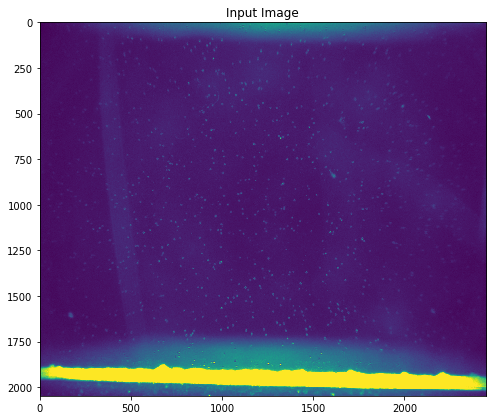

In [26]:
image = imread(FG_IMAGE_PATH)
plt.figure(figsize=(8.,8.))
plt.imshow(image)
plt.title("Input Image")
plt.show()

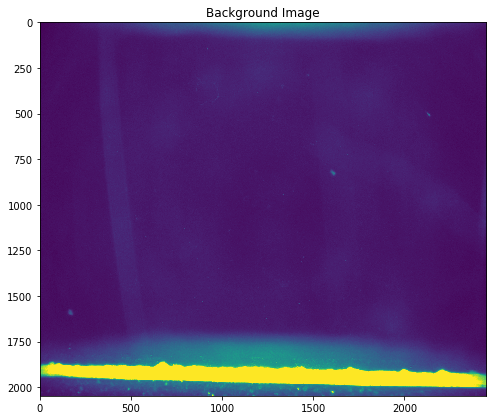

In [32]:
plt.figure(figsize=(8.,8.))
plt.imshow(bg_img)
plt.title("Background Image")
plt.show()

Apply Greg's code to align and clean the input image.

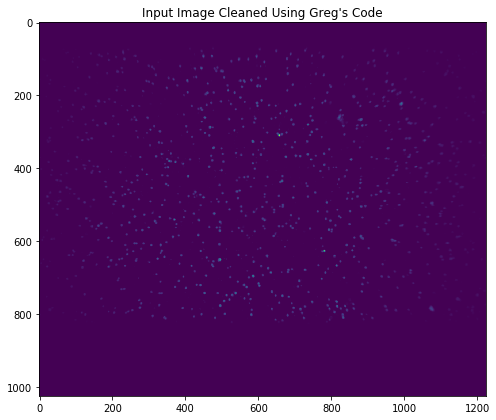

In [30]:
plt.figure(figsize=(8.,8.))
fg_cleaned, valid_area, info = pp.process_fg_image_from_path(FG_IMAGE_PATH)
plt.imshow(fg_cleaned)
plt.title("Input Image Cleaned Using Greg's Code")
plt.show()

Apply cross-correlation.

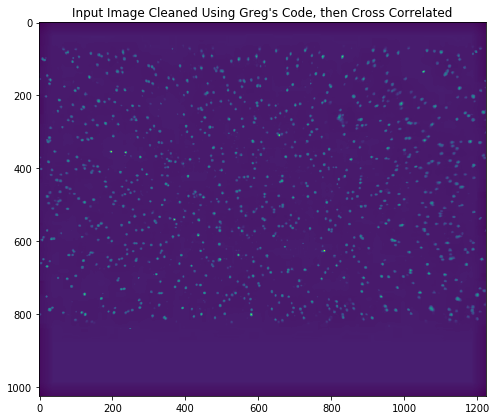

In [31]:
plt.figure(figsize=(8.,8.))
fg_cleaned_xcorr = cross_correlate(fg_cleaned)
plt.imshow(fg_cleaned_xcorr)
plt.title("Input Image Cleaned Using Greg's Code, then Cross Correlated")
plt.show()

Crop the processed FG image.

In [146]:
fg_cleaned_xcorr.shape

(1024, 1224)

In [153]:
ycrop = int((2048-948)/4)
xcrop = int((2448-1948)/4)
fg_cleaned_xcorr_cropped = fg_cleaned_xcorr[ycrop:-1*ycrop,xcrop:-1*xcrop]

Check that the processed FG image matches the GT

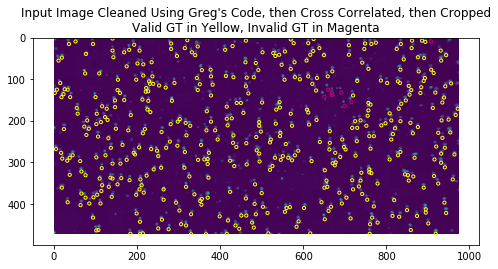

In [156]:
plt.figure(figsize=(8.,8.))
plt.imshow(fg_cleaned_xcorr_cropped)
plt.scatter(df.X_scaled - xcrop, df.Y_scaled - ycrop, s=10, facecolor='None', edgecolor=df.color, marker='o')
plt.title("Input Image Cleaned Using Greg's Code, then Cross Correlated, then Cropped\nValid GT in Yellow, Invalid GT in Magenta")
plt.show()

Count blobs

In [160]:
blobs = blob_dog(fg_cleaned_xcorr_cropped, min_sigma=5, max_sigma=15, threshold=0.009)
pred_count = len(blobs)
pred_count

404

## Get gt_count

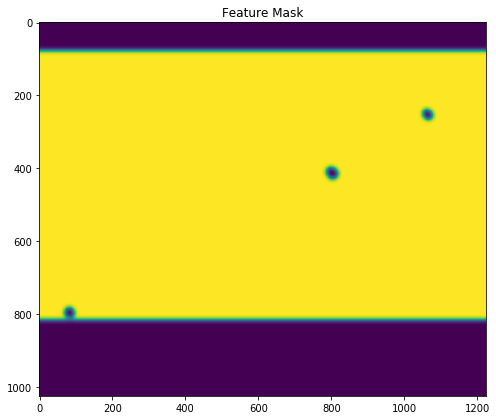

In [57]:
# Feature Mask
plt.figure(figsize=(8.,8.))
plt.imshow(info['feature_mask'])
plt.title("Feature Mask")
plt.show()

In [139]:
# GT
df = pd.read_csv('./all_test_gt_complete/image-cropped-rescaled-%s.csv' % name)

In [140]:
# Scaling GT
df['X_scaled'] = round(df['X']*(1/2)+xcrop)
df['Y_scaled'] = round(df['Y']*(1/2)+ycrop)

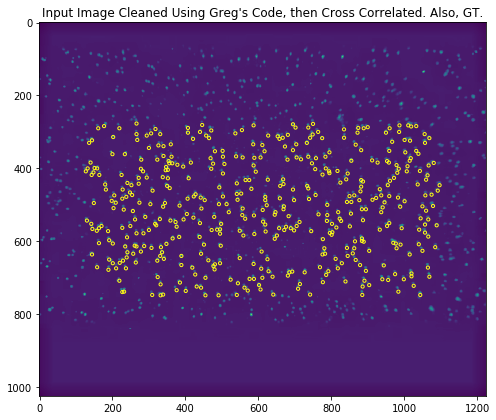

In [141]:
plt.figure(figsize=(8.,8.))
plt.imshow(fg_cleaned_xcorr)
plt.scatter(df.X_scaled, df.Y_scaled, s=10, facecolor='None', edgecolor='xkcd:yellow', marker='o')
plt.title("Input Image Cleaned Using Greg's Code, then Cross Correlated. Also, GT.")
plt.show()

In [142]:
# Applying feature mask to remove unwanted GT
mask = info['feature_mask']
df['valid'] = [0]*len(df)
df['color'] = ['']*len(df)
for ind in df.index:
    x = int(df['X_scaled'][ind])
    y = int(df['Y_scaled'][ind])
    valid = int(mask[y][x])
    df['valid'][ind] = valid
    if valid:
        color = 'xkcd:yellow'
    else:
        color = 'xkcd:magenta'
    df['color'][ind] = color

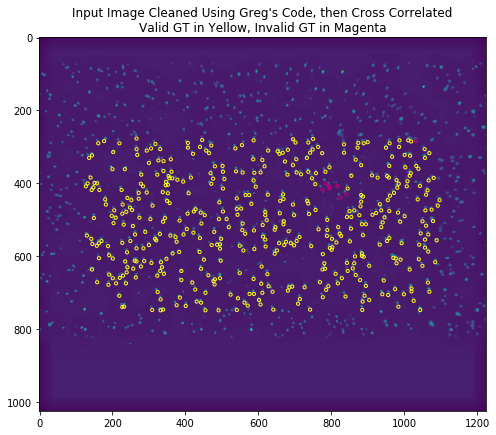

In [143]:
plt.figure(figsize=(8.,8.))
plt.imshow(fg_cleaned_xcorr)
plt.scatter(df.X_scaled, df.Y_scaled, s=10, facecolor='None', edgecolor=df.color, marker='o')
plt.title("Input Image Cleaned Using Greg's Code, then Cross Correlated\nValid GT in Yellow, Invalid GT in Magenta")
plt.show()

In [144]:
gt_count = len(df[df.valid==1])
gt_count

449

# Test all images

## Preprocessing: cci1 package

In [165]:
def plot(gt_counts, pred_counts, colors):
    plt.figure(figsize=(6,4), dpi=100)
    plt.scatter(gt_counts, pred_counts, facecolor='None', edgecolor=colors)
    plt.plot([0, 1300], [0, 1300], color='xkcd:green')
    plt.xlabel('Ground Truth Count')
    plt.ylabel('Predicted Count')

    slope, intercept, r_value, p_value, std_err = linregress(gt_counts, pred_counts)
    plt.plot(gt_counts, intercept + [slope*x for x in gt_counts], color='xkcd:gray')
    plt.title('#pred = %s*#GT + %s, r^2 = %s' % (str(round(slope,2)), str(round(intercept,2)), str(round(r_value**2,2))))

    handle_list = []
    handle_list.append(Line2D([0],[0], marker=None, color='xkcd:green', lw=2, label='# pred = # GT'))
    handle_list.append(Line2D([0],[0], marker=None, color='xkcd:gray', lw=2, label='# pred vs. # GT'))
    handle_list.append(Line2D([0],[0], marker='o', color='None',
                              markerfacecolor='None', markeredgecolor='m', label='image with bubble'))
    handle_list.append(Line2D([0],[0], marker='o', color='None',
                              markerfacecolor='None', markeredgecolor='c', label='image without bubble'))
    plt.legend(handles=handle_list, loc='lower right', fontsize=10)

    plt.show()

In [166]:
def test_threshold(threshold):
    gt_counts, pred_counts, colors = [], [], []
    for i in range(len(names)):
        if i%10==0:
            print(i, '/', len(names))
        name = names[i]
        
        # Get pred_count

        ## Ingest full-size, uncropped FG and BG images.

        BG_IMAGE_PATH = 'all_bg/background-%s.tif' % name
        ycrop = int((2048-948)/2)
        xcrop = int((2448-1948)/2)
        bg_img = imread(BG_IMAGE_PATH)
        info = pp.set_bg_image(bg_img)
        FG_IMAGE_PATH = 'raw_images/image-%s.tif' % name

        ## Apply Greg's code to align and clean the input image.

        fg_cleaned, valid_area, info = pp.process_fg_image_from_path(FG_IMAGE_PATH)

        ## Apply cross-correlation.

        fg_cleaned_xcorr = cross_correlate(fg_cleaned)

        ## Crop the processed FG image.

        ycrop = int((2048-948)/4)
        xcrop = int((2448-1948)/4)
        fg_cleaned_xcorr_cropped = fg_cleaned_xcorr[ycrop:-1*ycrop,xcrop:-1*xcrop]

        ## Count blobs

        blobs = blob_dog(fg_cleaned_xcorr_cropped, min_sigma=5, max_sigma=15, threshold=threshold)
        pred_count = len(blobs)

        # Get gt_count

        df = pd.read_csv('./all_test_gt_complete/image-cropped-rescaled-%s.csv' % name)
        df['X_scaled'] = round(df['X']*(1/2)+xcrop)
        df['Y_scaled'] = round(df['Y']*(1/2)+ycrop)

        ## Applying feature mask to remove unwanted GT
        mask = info['feature_mask']
        df['valid'] = [0]*len(df)
        df['color'] = ['']*len(df)
        for ind in df.index:
            x = int(df['X_scaled'][ind])
            y = int(df['Y_scaled'][ind])
            valid = int(mask[y][x])
            df['valid'][ind] = valid
            if valid:
                color = 'xkcd:yellow'
            else:
                color = 'xkcd:magenta'
            df['color'][ind] = color

        gt_count = len(df[df.valid==1])
        
        gt_counts.append(gt_count)
        pred_counts.append(pred_count)
        if name in bubble_image_names:
            colors.append('m')
        else:
            colors.append('c')
    plot(gt_counts, pred_counts, colors)

In [167]:
names_raw = pd.read_csv('names_2.csv', header=None)
names = [x[0][23:-4] for x in names_raw.values]
names_raw = pd.read_csv('names_test_2.csv', header=None)
names_test = [x[0][14:] for x in names_raw.values]

In [168]:
thresholds = np.arange(0.001, 0.015, 0.001)

--------
threshold = 0.001000
0 / 26
10 / 26
20 / 26


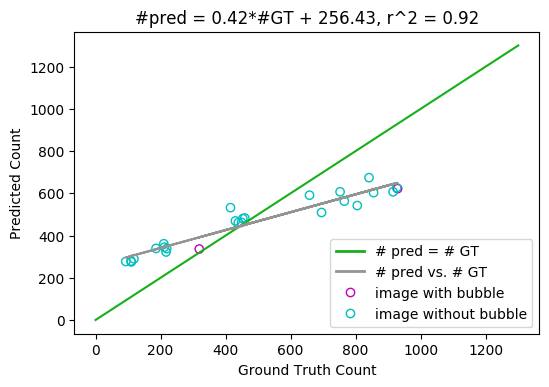

--------
threshold = 0.002000
0 / 26
10 / 26
20 / 26


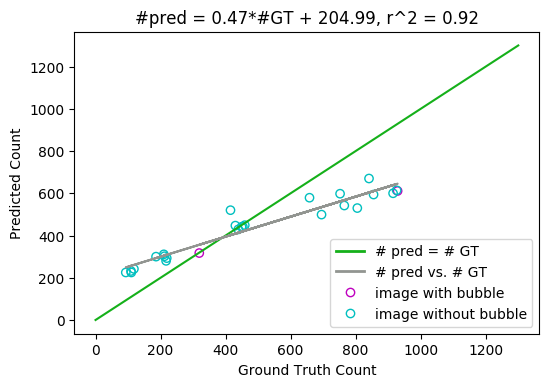

--------
threshold = 0.003000
0 / 26
10 / 26
20 / 26


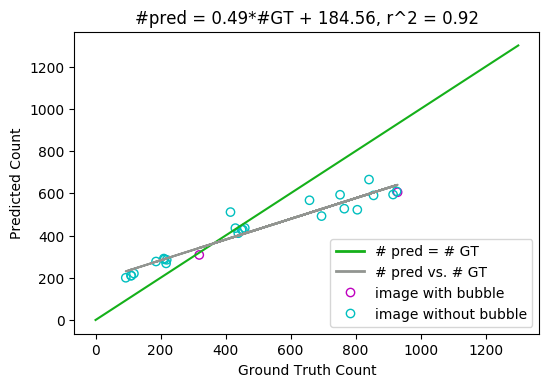

--------
threshold = 0.004000
0 / 26
10 / 26
20 / 26


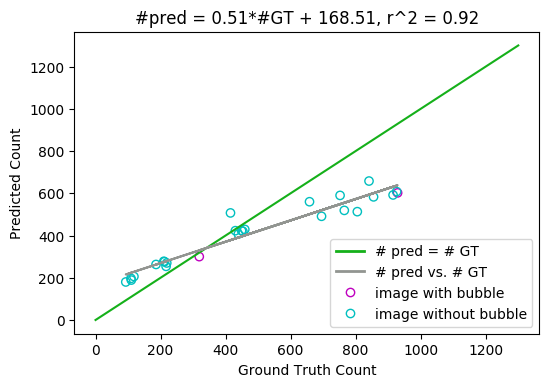

--------
threshold = 0.005000
0 / 26
10 / 26
20 / 26


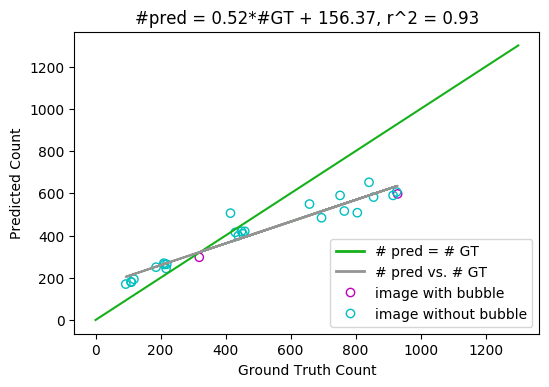

--------
threshold = 0.006000
0 / 26
10 / 26
20 / 26


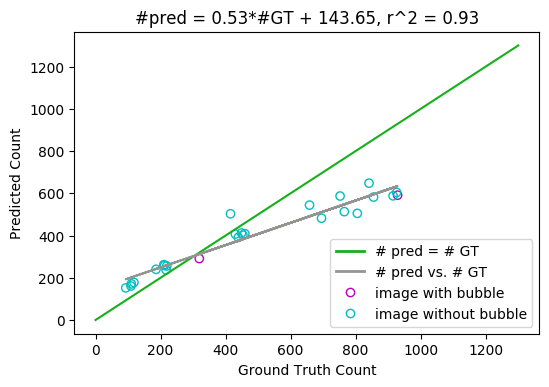

--------
threshold = 0.007000
0 / 26
10 / 26
20 / 26


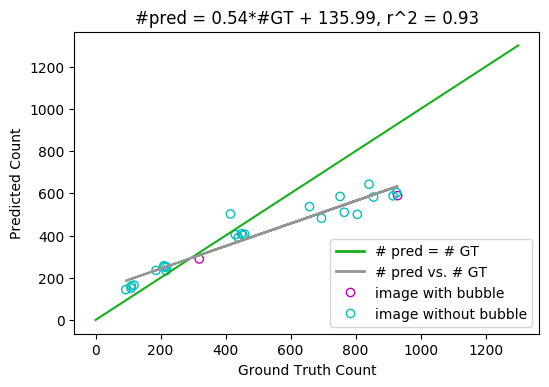

--------
threshold = 0.008000
0 / 26
10 / 26
20 / 26


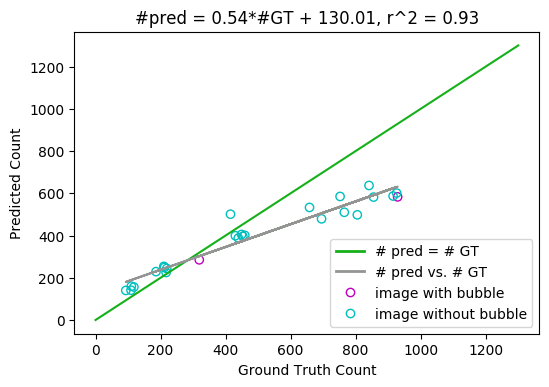

--------
threshold = 0.009000
0 / 26
10 / 26
20 / 26


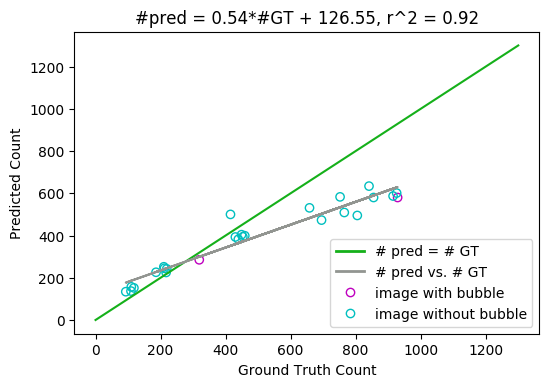

--------
threshold = 0.010000
0 / 26
10 / 26
20 / 26


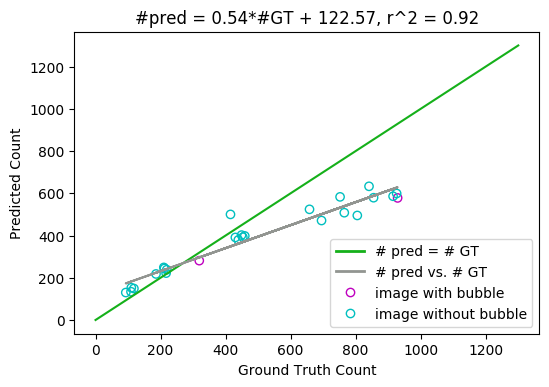

--------
threshold = 0.011000
0 / 26
10 / 26
20 / 26


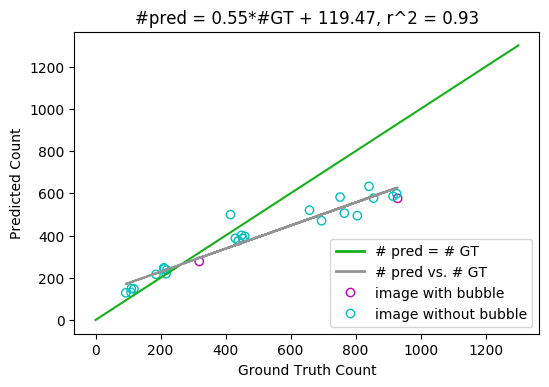

--------
threshold = 0.012000
0 / 26
10 / 26
20 / 26


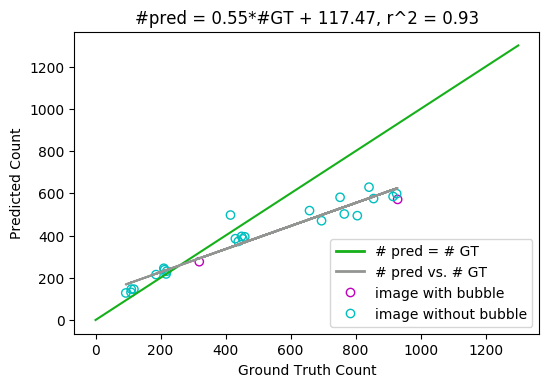

--------
threshold = 0.013000
0 / 26
10 / 26
20 / 26


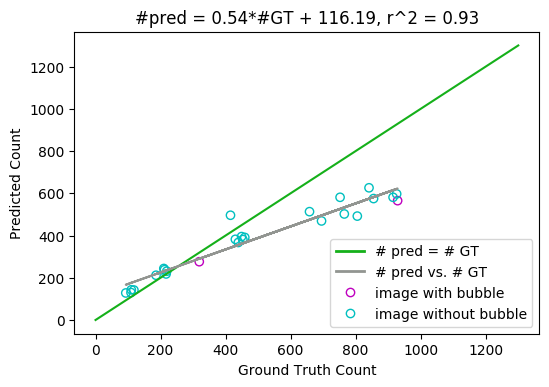

--------
threshold = 0.014000
0 / 26
10 / 26
20 / 26


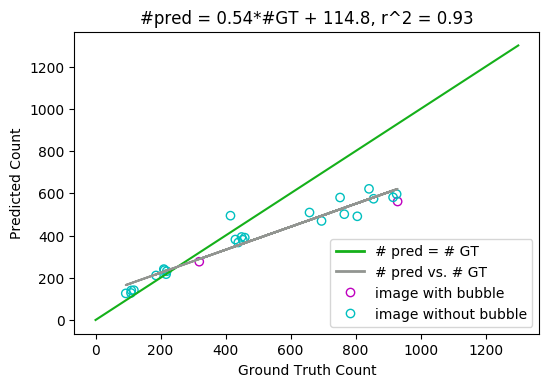

In [170]:
for threshold in thresholds:
    print('--------\nthreshold = %f' % threshold)
    test_threshold(threshold)

## Preprocessing: normxcorr Only

Using a different intensity threshold for images with bubbles and with linear transformation

In [171]:
names_raw = pd.read_csv('names_2.csv', header=None)
names = [x[0][23:-4] for x in names_raw.values]
names_raw = pd.read_csv('names_test_2.csv', header=None)
names_test = [x[0][14:] for x in names_raw.values]

In [172]:
# These linear transformation values come from
# benchmark_blob_dog_new_test_images_w_pre-processing_kernelSize150.ipynb
slope_use, intercept_use = 0.65, 115.92

In [173]:
print(datetime.now())
gt_counts, pred_counts, colors = [], [], []
for i in range(len(names)):
    if i%10==0:
        print(i, '/', len(names))
    name = names[i]
    im = imread('raw_images_cropped/image-cropped-%s.tif' % name)
    im = cross_correlate(im)
    df = pd.read_csv('all_test_gt_complete/image-cropped-rescaled-%s.csv' % name)
    if name in bubble_image_names:
        colors.append('m')
        threshold = 0.08
    else:
        colors.append('c')
        threshold = 0.1
    blobs = blob_dog(im, min_sigma=5, max_sigma=15, threshold=threshold)
    gt_counts.append(len(df))
    count_blobs_raw = len(blobs)
    count_blobs = (count_blobs_raw - intercept_use)/slope_use
    pred_counts.append(count_blobs)
print(datetime.now())

2021-08-01 18:49:34.433013
0 / 26
10 / 26
20 / 26
2021-08-01 18:50:04.215378


^ 0.994 seconds each image

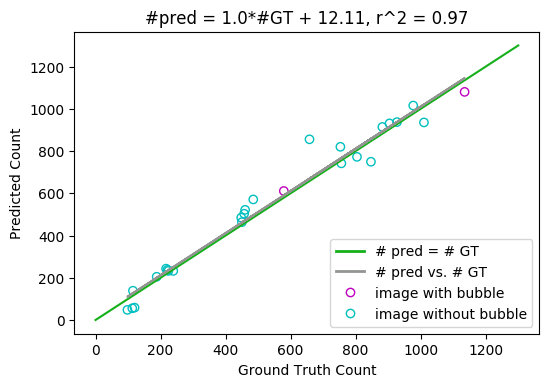

In [174]:
plt.figure(figsize=(6,4), dpi=100)
plt.scatter(gt_counts, pred_counts, facecolor='None', edgecolor=colors)
plt.plot([0, 1300], [0, 1300], color='xkcd:green')
plt.xlabel('Ground Truth Count')
plt.ylabel('Predicted Count')

slope, intercept, r_value, p_value, std_err = linregress(gt_counts, pred_counts)
plt.plot(gt_counts, intercept + [slope*x for x in gt_counts], color='xkcd:gray')
plt.title('#pred = %s*#GT + %s, r^2 = %s' % (str(round(slope,2)), str(round(intercept,2)), str(round(r_value**2,2))))

handle_list = []
handle_list.append(Line2D([0],[0], marker=None, color='xkcd:green', lw=2, label='# pred = # GT'))
handle_list.append(Line2D([0],[0], marker=None, color='xkcd:gray', lw=2, label='# pred vs. # GT'))
handle_list.append(Line2D([0],[0], marker='o', color='None',
                          markerfacecolor='None', markeredgecolor='m', label='image with bubble'))
handle_list.append(Line2D([0],[0], marker='o', color='None',
                          markerfacecolor='None', markeredgecolor='c', label='image without bubble'))
plt.legend(handles=handle_list, loc='lower right', fontsize=10)

plt.show()